In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

In [2]:
class Clean_Signal_Generator:
    def __init__(self, total_time=1000, num_sources=100, mean_amp=10, sigma_amp=2, freq_range=(1e-4, 1e-1),
                 amp_distribution_func=None, omega_distribution_func=None):
        """
        Initializes the Clean_Signal_Generator class with given parameters.

        Parameters:
        total_time : float
            | The total time duration of the signal.
        num_sources : int
            | The number of sinusoidal components in the signal.
        mean_amp : float
            | The mean amplitude of the sinusoidal components.
        sigma_amp : float
            | The standard deviation of the amplitudes of the sinusoidal components.
        freq_range : tuple of (float, float)
            | A tuple containing the minimum and maximum frequencies for the sinusoidal components.
        amp_distribution_func : callable, optional
            | A function to generate amplitudes for the sinusoidal components.
        omega_distribution_func : callable, optional
            | A function to generate angular frequencies for the sinusoidal components.
        """
        self.total_time = total_time
        self.num_sources = num_sources
        self.mean_amp = mean_amp
        self.sigma_amp = sigma_amp
        self.min_freq, self.max_freq = freq_range
        self.amp_distribution_func = amp_distribution_func if amp_distribution_func else self.default_amp_distribution
        self.omega_distribution_func = omega_distribution_func if omega_distribution_func else self.default_omega_distribution
        self.A = None
        self.omega = None
        self.theta = None
        self.generated_signal = None

    def default_amp_distribution(self, size):
        """
        Default amplitude distribution using normal distribution.
        """
        return np.random.normal(loc=self.mean_amp, scale=self.sigma_amp, size=size)

    def default_omega_distribution(self, size):
        """
        Default angular frequency distribution using normal distribution.
        """
        mean_freq = (self.min_freq + self.max_freq) / 2
        sigma_freq = (self.max_freq - self.min_freq) / 6
        return np.random.normal(loc=2 * np.pi * mean_freq, scale=2 * np.pi * sigma_freq, size=size)

    def generate_signal(self, amp_uselog=False):
        """
        Generates a clean signal composed of multiple sinusoidal components and returns it as a DataFrame.

        Parameters:
        amp_uselog : bool, optional
            | If True, the amplitude values are sampled from a log-normal distribution.
            | If False, they are sampled from a normal distribution. Default is False.

        Returns:
        A DataFrame containing the generated signal, with columns 'Time' and 'Clean_Signal'.
        """
        time_interval = 0.05 / self.max_freq
        num_samples = int(self.total_time / time_interval)
        t = np.linspace(0, self.total_time, num_samples, endpoint=False)
        d_t = np.zeros(num_samples)

        if amp_uselog:
            mean_logamp = np.log(self.mean_amp)
            sigma_logamp = np.log(self.sigma_amp)
            lnA = np.random.normal(loc=mean_logamp, scale=sigma_logamp, size=self.num_sources)
            self.A = np.exp(lnA)
        else:
            self.A = self.amp_distribution_func(self.num_sources)

        self.omega = self.omega_distribution_func(self.num_sources)
        self.theta = np.random.uniform(0, 2 * np.pi, size=self.num_sources)

        for i in range(self.num_sources):
            d_t += self.A[i] * np.sin(self.omega[i] * t + self.theta[i])

        self.generated_signal = pd.DataFrame({'Time': t, 'Signal': d_t})
        return self.generated_signal

    def plot_individual_components(self, num_components=5):
        """
        Plots individual sinusoidal components of the generated signal.

        Parameters:
        num_components : int, optional
            | The number of components to plot. Default is 5.
        """
        if self.generated_signal is not None:
            plt.figure(figsize=(10, 6))
            t = self.generated_signal['Time']
            for i in range(min(num_components, self.num_sources)):
                component_signal = self.A[i] * np.sin(self.omega[i] * t + self.theta[i])
                plt.plot(t, component_signal, label=f'Component {i + 1}')
            plt.xlabel('Time')
            plt.ylabel('Signal')
            plt.title(f'Individual Components (Up to {num_components})')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("Please generate the signal first.")

In [3]:
CSG = Clean_Signal_Generator(num_sources=1)
clean_signal = CSG.generate_signal(amp_uselog=True)

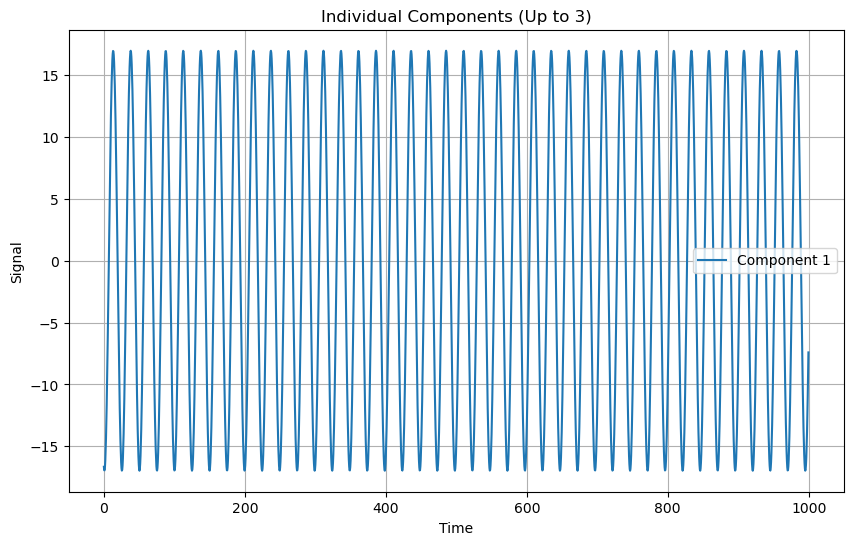

In [4]:
CSG.plot_individual_components(num_components=3)

In [5]:
CSG.omega

array([0.25276727])

In [6]:
CSG.A

array([16.97714328])

In [7]:
CSG.theta

array([4.51790098])

In [8]:
class Noise_Generator:
    def __init__(self, total_time=1000, psd_file=None, freq_range=(1e-4, 1e-1), noise_amplitude=10):
        """
        Initializes the Noise_Generator class with given parameters.

        Parameters:
        total_time : float
            The total time duration for the noise signal.
        psd_file : str, optional
            Path to the PSD file used for generating noise based on power spectral density.
        default_freq_range : tuple of (float, float), optional
            A tuple containing the default minimum and maximum frequencies for the noise components.
        noise_amplitude : float, optional
            The amplitude scaling factor for the generated noise.
        """
        self.total_time = total_time
        self.psd_file = psd_file
        self.freq_range = freq_range
        self.noise_amplitude = noise_amplitude

    def read_psd_data(self):
        """
        Reads the power spectral density data from the PSD file and returns it.

        Returns:
        psd_freqs, psd_amps : numpy arrays
            Arrays containing the frequencies and corresponding amplitudes from the PSD data.
        """
        try:
            psd_data = np.loadtxt(self.psd_file)
            psd_freqs = psd_data[:, 0]
            psd_amps = psd_data[:, 1]
            return psd_freqs, psd_amps
        except IOError as e:
            print(f"Error reading PSD file: {e}")
            return None, None

    def plot_psd(self):
        """
        Plots the Power Spectral Density (PSD) data from the PSD file.
        """
        psd_freqs, psd_amps = self.read_psd_data()

        if psd_freqs is not None and psd_amps is not None:
            plt.figure(figsize=(10, 6))
            plt.plot(psd_freqs, psd_amps)
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.title('Power Spectral Density (Log-scale)')
            plt.grid(True)
            plt.show()
        else:
            print("PSD data not available or unable to read PSD file.")
            
    def get_freq_range(self):
        """
        Retrieves the frequency range either from the PSD file or the default frequency range.

        Returns:
        freq_range : tuple of (float, float)
            A tuple containing the minimum and maximum frequencies for the noise components.
        """
        if self.psd_file:
            psd_freqs, _ = self.read_psd_data()
            if psd_freqs is not None:
                return (np.min(psd_freqs), np.max(psd_freqs))
            else:
                print("Unable to read PSD file, using default frequency range.")
        return self.freq_range

    def generate_noise(self, noise_type='white'):
        """
        Generates noise based on the specified type ('white' or 'psd') and returns it as a DataFrame.

        Parameters:
        noise_type : str, optional
            The type of noise to generate. Options are 'white' for white noise and 'psd' for noise based on a PSD file.

        Returns:
        noise_signal_df : pandas.DataFrame
            A DataFrame containing the generated noise signal, with columns 'Time' and 'Noise'.
        """
        time_interval = 0.05 / self.freq_range[1]  # Ensure at least 20 samples per highest frequency component
        num_samples = int(self.total_time / time_interval)
        t = np.linspace(0, self.total_time, num_samples, endpoint=False)

        if noise_type == 'white':
            noise = np.random.normal(scale=self.noise_amplitude, size=num_samples)
        elif noise_type == 'psd' and self.psd_file:
            psd_freqs, psd_amps = self.read_psd_data()
            sample_rate = 1.0 / time_interval  # Calculate the sample rate
            freqs = np.fft.fftfreq(num_samples, d=1 / sample_rate)
            
            noise_psd = np.interp(freqs, psd_freqs, psd_amps, left=0, right=0)
            noise_psd_fft = np.sqrt(noise_psd)
            noise = np.fft.ifft(noise_psd_fft).real

        noise_df = pd.DataFrame({'Time': t, 'Signal': noise})
        return noise_df

In [9]:
NG = Noise_Generator(psd_file='LIGOL_noise_psd.txt')

In [10]:
noise = NG.generate_noise()

In [23]:
class Signal_Analyzer:
    @staticmethod
    def plot_signal(signal_df, column='Signal', title='Signal Plot', ax=None):
        """
        Plots a given signal from a DataFrame.

        Parameters:
        signal_df : pandas.DataFrame
            DataFrame containing the signal to plot, with at least 'Time' and the specified 'column'.
        column : str, optional
            The column name in signal_df that contains the signal values. Default is 'Signal'.
        title : str, optional
            The title of the plot. Default is 'Signal Plot'.
        """
        if column not in signal_df.columns:
            raise ValueError(f"Column '{column}' not found in DataFrame.")

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(signal_df['Time'], signal_df[column])
        ax.set_xlabel('Time')
        ax.set_ylabel('Amplitude')
        ax.set_title(title)
        ax.grid(True)

    @staticmethod
    def plot_fft(signal_df, column='Signal', title='FFT Spectrum', use_abs=True, ax=None):
        """
        Plots the Fast Fourier Transform (FFT) of a given signal, with an option to plot using absolute values.

        Parameters:
        signal_df : pandas.DataFrame
            DataFrame containing the signal to plot, with at least 'Time' and the specified 'column'.
        column : str, optional
            The column name in signal_df that contains the signal values. Default is 'Signal'.
        title : str, optional
            The title of the plot. Default is 'FFT Spectrum'.
        use_abs : bool, optional
            Whether to plot the FFT using absolute values. Default is False.
        """
        if column not in signal_df.columns:
            raise ValueError(f"Column '{column}' not found in DataFrame.")

        signal = signal_df[column].to_numpy()
        sample_rate = 1.0 / (signal_df['Time'].iloc[1] - signal_df['Time'].iloc[0])
        fft_signal = fft(signal)
        fft_freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)

        y_values = np.abs(fft_signal) if use_abs else fft_signal

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(fft_freqs[:len(signal)//2], y_values[:len(signal)//2])
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Amplitude' if use_abs else 'Value')
        ax.set_title(title)
        ax.grid(True)

    @staticmethod
    def combine_signals(signal_df1, signal_df2, column1='Signal', column2='Signal'):
        """
        Combines two signals from two DataFrames and returns a new DataFrame with the combined signal.

        Parameters:
        signal_df1 : pandas.DataFrame
            DataFrame containing the first signal to combine, with at least 'Time' and the specified 'column1'.
        signal_df2 : pandas.DataFrame
            DataFrame containing the second signal to combine, with at least 'Time' and the specified 'column2'.
        column1 : str, optional
            The column name in signal_df1 that contains the first signal values. Default is 'Signal'.
        column2 : str, optional
            The column name in signal_df2 that contains the second signal values. Default is 'Signal'.

        Returns:
        combined_signal_df : pandas.DataFrame
            A DataFrame containing the combined signal, with columns 'Time' and 'Combined_Signal'.
        """
        if column1 not in signal_df1.columns or column2 not in signal_df2.columns:
            raise ValueError("Column not found in one or both DataFrames.")

        # Ensure the time axes are aligned
        if not np.array_equal(signal_df1['Time'], signal_df2['Time']):
            raise ValueError("Time axes of the two signals are not aligned.")

        combined_signal = signal_df1[column1] + signal_df2[column2]
        combined_signal_df = signal_df1[['Time']].copy()
        combined_signal_df['Combined_Signal'] = combined_signal

        return combined_signal_df

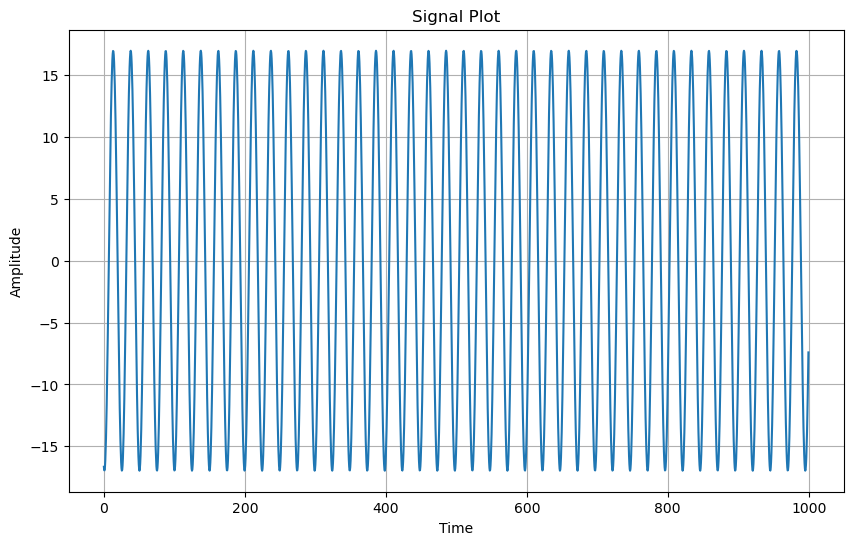

In [12]:
Signal_Analyzer.plot_signal(clean_signal)

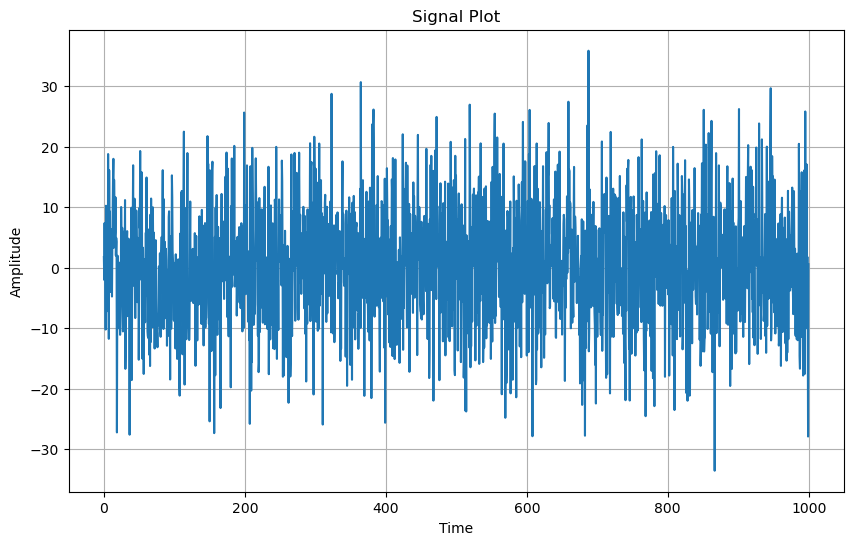

In [13]:
Signal_Analyzer.plot_signal(noise)

C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


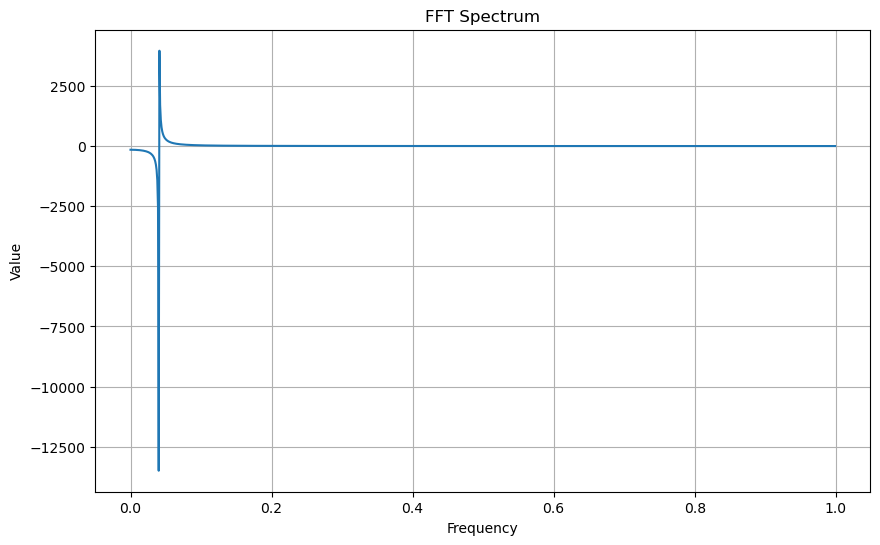

In [14]:
Signal_Analyzer.plot_fft(clean_signal)

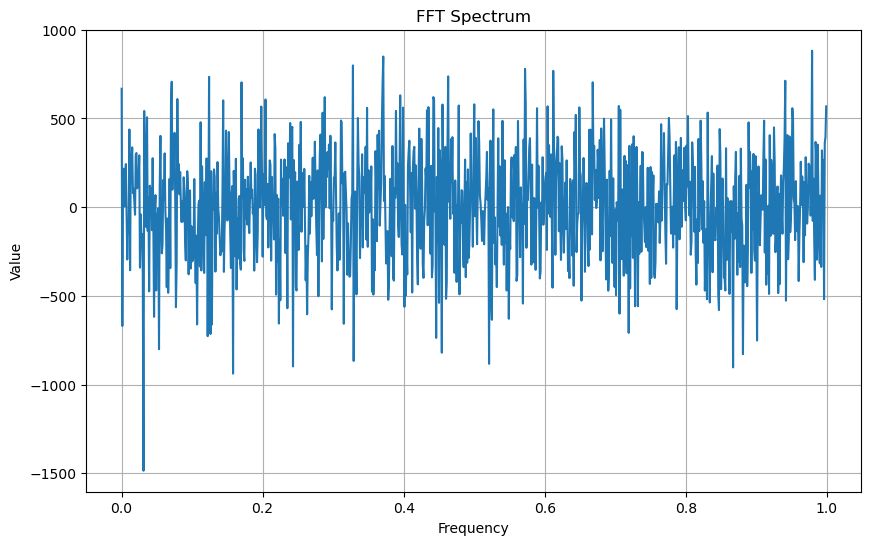

In [15]:
Signal_Analyzer.plot_fft(noise)

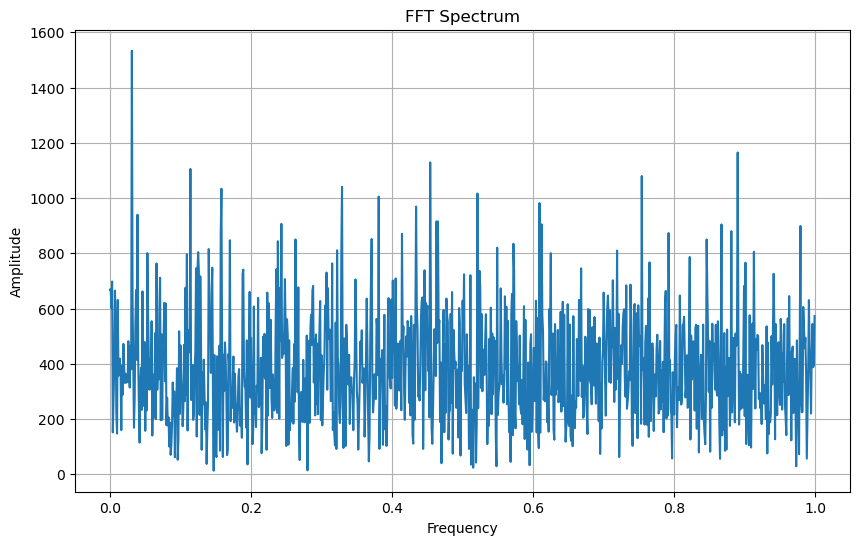

In [16]:
Signal_Analyzer.plot_fft(noise, use_abs=True)

In [31]:
combined_signal = Signal_Analyzer.combine_signals(clean_signal, noise)

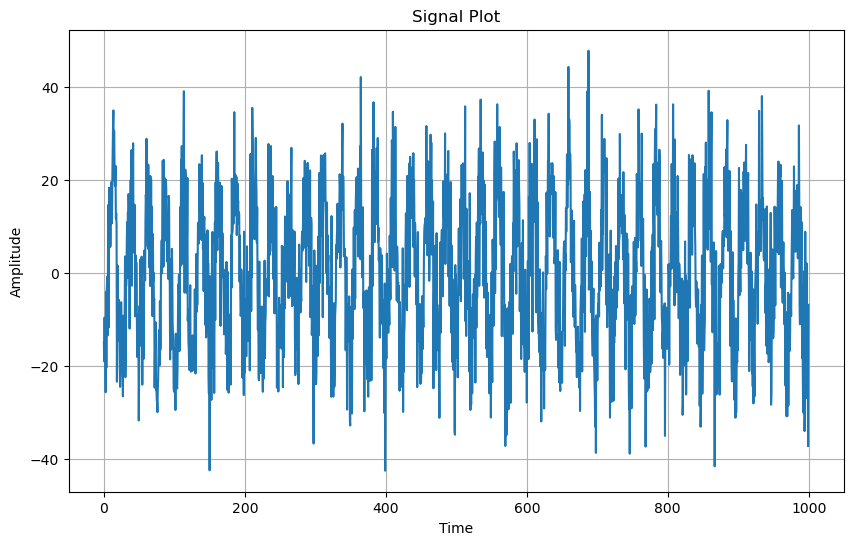

In [32]:
Signal_Analyzer.plot_signal(combined_signal, column='Combined_Signal')

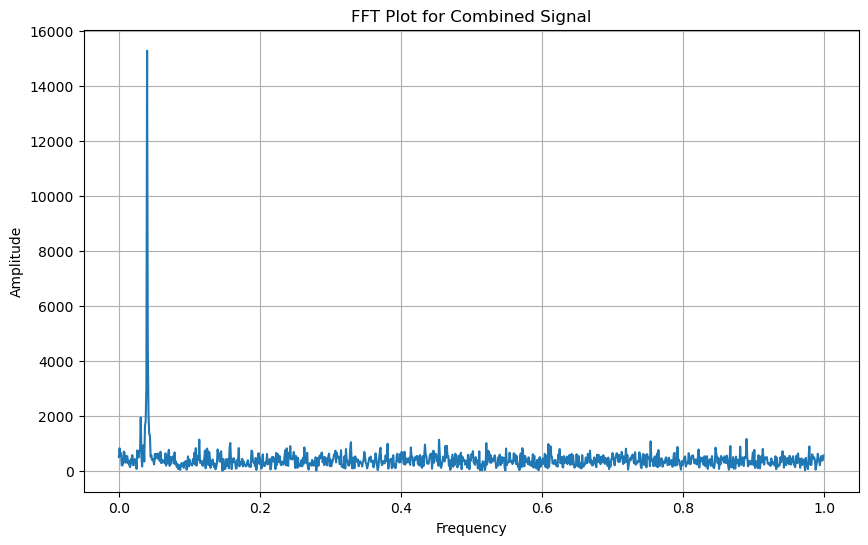

In [33]:
Signal_Analyzer.plot_fft(combined_signal, column='Combined_Signal', title='FFT Plot for Combined Signal')

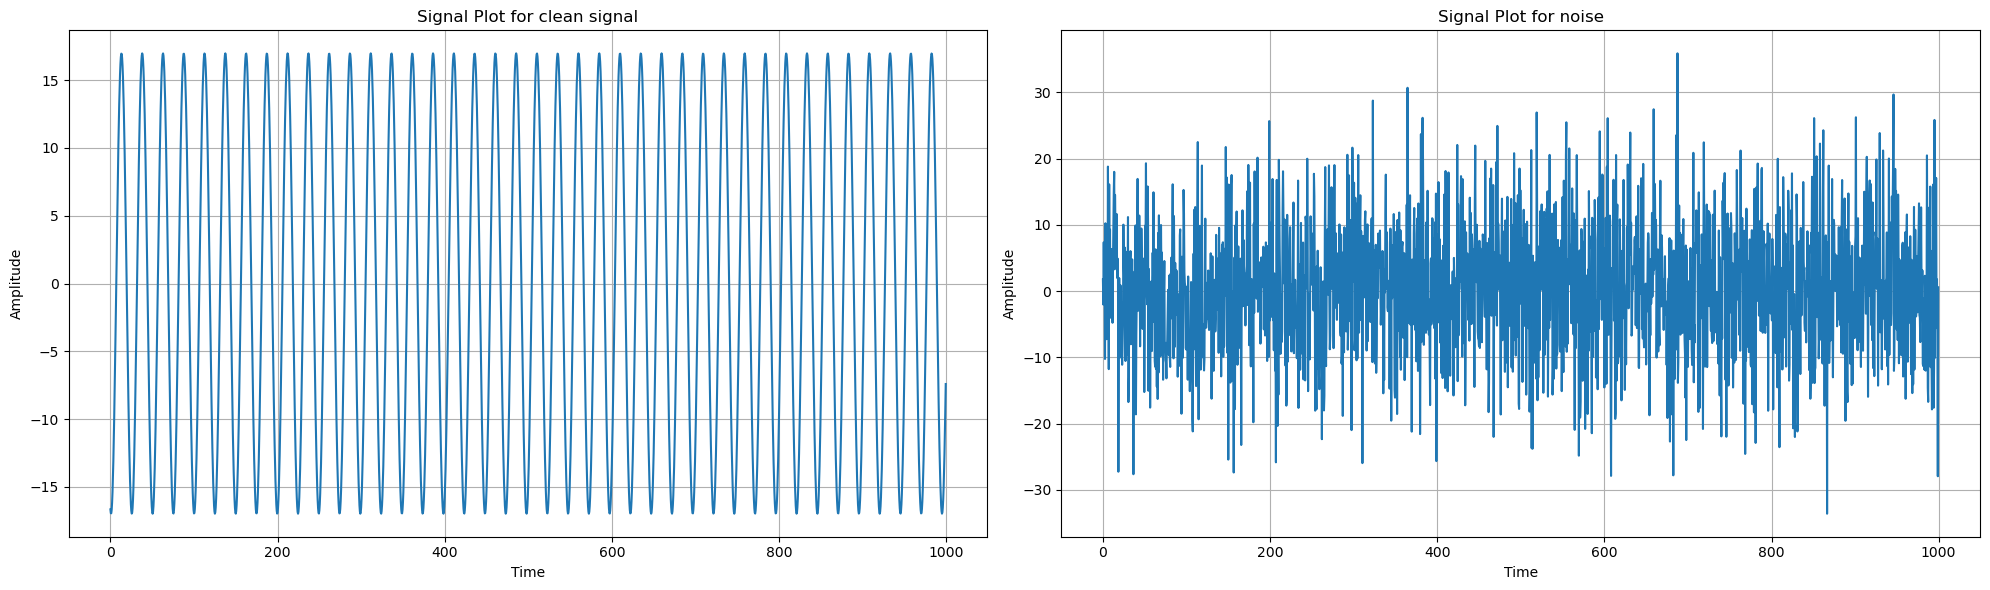

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

Signal_Analyzer.plot_signal(clean_signal, column='Signal', title='Signal Plot for clean signal', ax=axs[0])

Signal_Analyzer.plot_signal(noise, column='Signal', title='Signal Plot for noise', ax=axs[1])

plt.tight_layout()
plt.show()

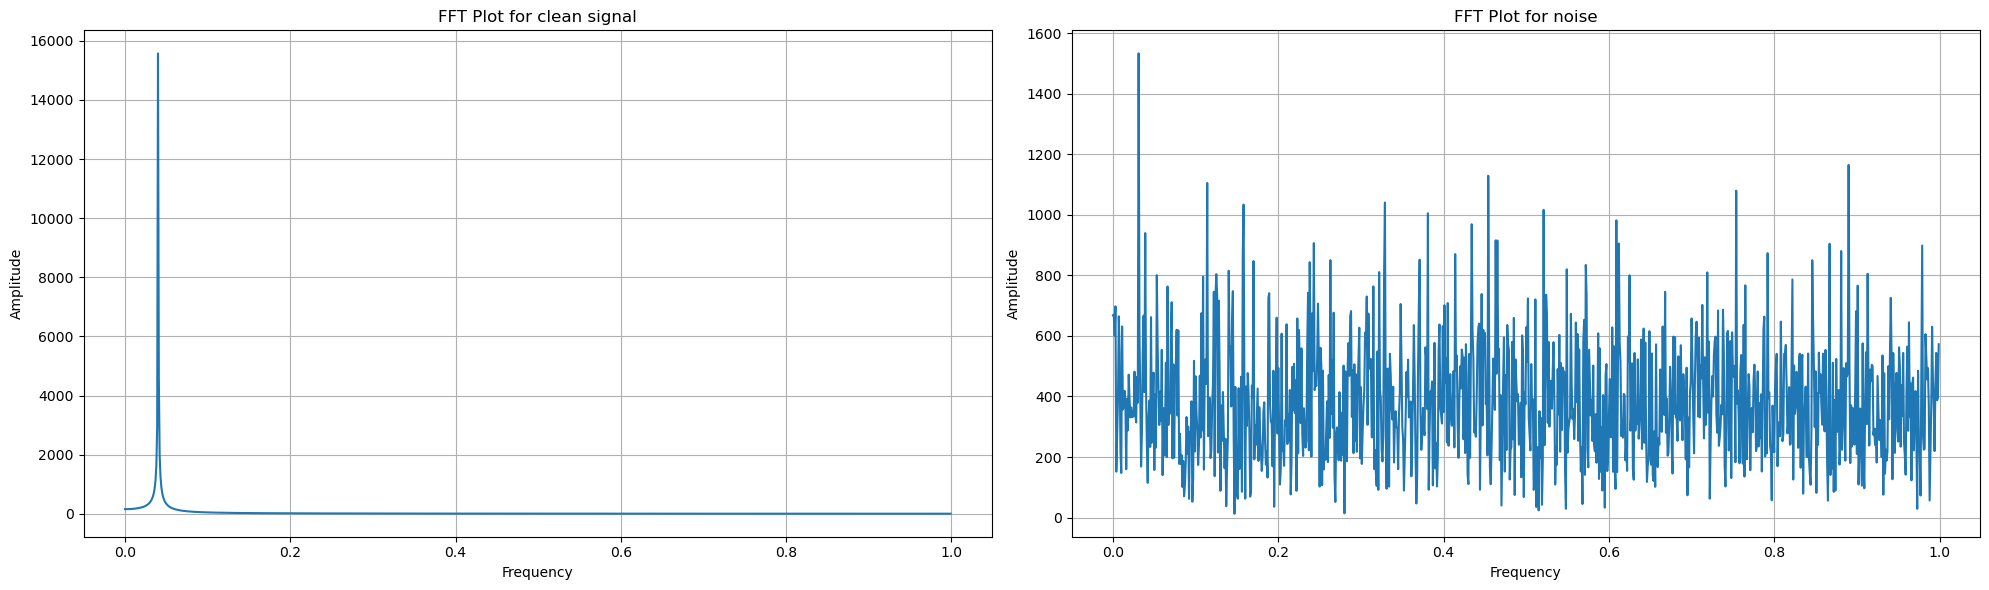

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

Signal_Analyzer.plot_fft(clean_signal, column='Signal', title='FFT Plot for Clean Signal', ax=axs[0])

Signal_Analyzer.plot_fft(noise, column='Signal', title='FFT Plot for Noise', ax=axs[1])

plt.tight_layout()
plt.show()